# KNN

## Configuraciones iniciales


Cargamos las bibliotecas que se van a estar usando a lo largo de este notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from preprocessing import prepararSetDeDatos
from preprocessing import knnPreprocessing

## Carga y preparacion del set de datos

In [5]:
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')

In [6]:
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')

In [7]:
X,y = prepararSetDeDatos(X,y)

## Funciones auxiliares

In [8]:
def obtenerMejoresHiperparametros(datosPreprocesados):
    mejor_distancia = None
    mejor_metrica = None
    mejor_valor = 0
    mejor_k = None
    y_array=np.array(y)
    for distancia in ['uniform', 'distance']:
        for metrica in ['minkowski','cosine','chebyshev','correlation']:
            for k in [2,3,4,5,6,7,8,9,10,15,20,25,30]:
                kf = StratifiedKFold(n_splits=8)
                metricas = []
                for fold_idx, (train_index, test_index) in enumerate(kf.split(datosPreprocesados, y_array)):
                    knn = KNeighborsClassifier(n_neighbors = k, weights = distancia,  metric = metrica, n_jobs = -1)
                    knn.fit(datosPreprocesados[train_index], y_array[train_index].ravel())
                    predicciones = knn.predict(datosPreprocesados[test_index])
                    score_obtenida = roc_auc_score(y_array[test_index],predicciones)
                    metricas.append(score_obtenida)

                if np.mean(metricas) >= mejor_valor:
                    mejor_valor = np.mean(metricas)
                    mejor_k = k
                    mejor_distancia = distancia
                    mejor_metrica = metrica
            
    return mejor_valor, mejor_k, mejor_distancia, mejor_metrica

## KNN

In [9]:
X_knn = knnPreprocessing(X)

In [10]:
mejor_valor, mejor_k, mejor_distancia, mejor_metrica = obtenerMejoresHiperparametros(X_knn)

In [11]:
print(mejor_valor.round(3))
print(mejor_k)
print(mejor_distancia)
print(mejor_metrica)

0.78
7
distance
correlation


In [12]:
knn = KNeighborsClassifier(n_neighbors = mejor_k, weights = mejor_distancia, metric = mejor_metrica)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.25, random_state=0)

In [14]:
knn.fit(X_train, y_train)

<ipython-input-14-144fd69ce732>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)


KNeighborsClassifier(metric='correlation', n_neighbors=7, weights='distance')

In [15]:
y_pred = knn.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.82      0.82      0.82       121
      Vuelve       0.72      0.72      0.73        80

    accuracy                           0.78       201
   macro avg       0.77      0.77      0.77       201
weighted avg       0.78      0.78      0.78       201



In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

Text(45.72222222222221, 0.5, 'Real')

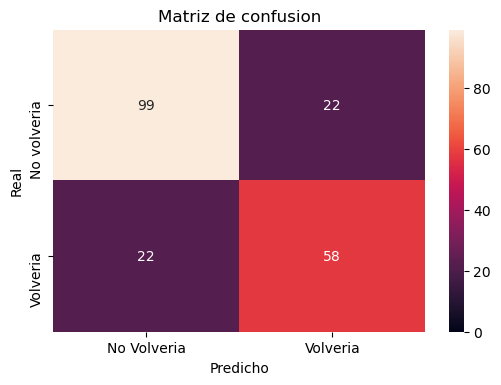

In [18]:
fig, ax = plt.subplots(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, vmin = 0, yticklabels=["No volveria","Volveria"], xticklabels=[ "No Volveria","Volveria"], ax=ax)
ax.set_title("Matriz de confusion")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")

EXPLICACION???????

Graficamos ahora la curva ROC para ambos casos.

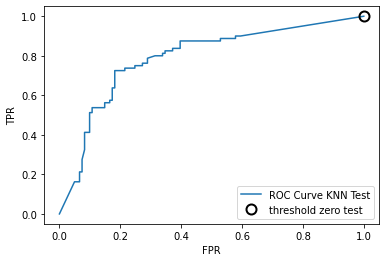

In [19]:
fpr_knn_test,tpr_knn_test,thresholds_knn_test = roc_curve(y_test,knn.predict_proba(X_test)[:,1])

zero_test = np.argmin(np.abs(thresholds_knn_test))

plt.plot(fpr_knn_test,tpr_knn_test,label="ROC Curve KNN Test")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr_knn_test[zero_test],tpr_knn_test[zero_test],'o',markersize=10,label="threshold zero test",fillstyle="none",c="k",mew=2)

plt.legend(loc=4)
plt.show()

EXPLICACION??????

In [20]:
auc_knn = roc_auc_score(y_test,knn.predict_proba(X_test)[:, 1])
print("AUC para KNN: {:.3f}".format(auc_knn))

AUC para KNN: 0.790


## Conclusiones KNN